# Setup imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('..')
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

c:\Users\54115\anaconda3\envs\oasis\Lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [23]:
def plot_trace(datos, c ,b,s , groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    #if groundtruth:
    #    plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(datos, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    #if groundtruth:
    #    for k in np.where(true_s)[0]:
    #        plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.show()
    #print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    #print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

# Load raw fluorescence data 
This data happend to have a fast rise time and we model it with an AR(1) process, see below for slower rise time and AR(2).

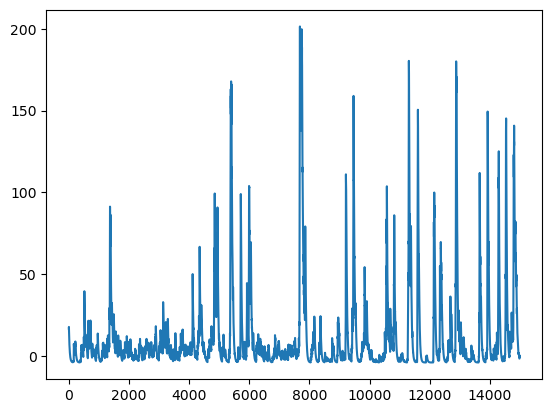

15000

In [16]:
p = r'c:\Users\54115\Desktop\Doctorado\ARCHIVOS\CEBRA\neural_data_simon_s1.npz'
a = np.load(p )
calcio1 = np.array(a['neural'][0]) 
plt.plot(calcio1)
plt.show()
len(calcio1)

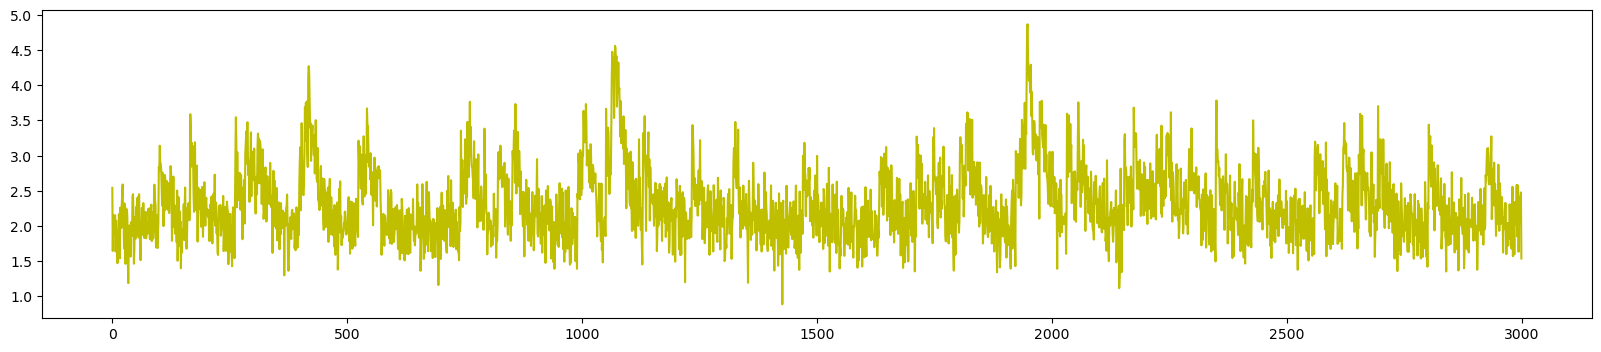

array([2.54013883, 1.64146887, 2.15495223, ..., 2.37323628, 2.47443479,
       1.53452061])

In [7]:
# here we generate some simulated fluorescence data and plot it
true_b = 2
y, true_c, true_s = map(np.squeeze, gen_data(N=1, b=true_b, seed=0))
plt.figure(figsize=(20,4))
plt.plot(y, c='y')
plt.show()
y

# Deconvolve 

### With $\ell_1$ penalty we obtain the global minimum of the convex problem 
If we only have the trace and no further info, simply calling deconvolve tries to estimate it from the data 

In [28]:
%time c, s, b, g, lam = deconvolve(calcio1, penalty=1)

CPU times: total: 109 ms
Wall time: 44.8 ms


#### Plot results
Because we happen to have ground truth data, we show it too 

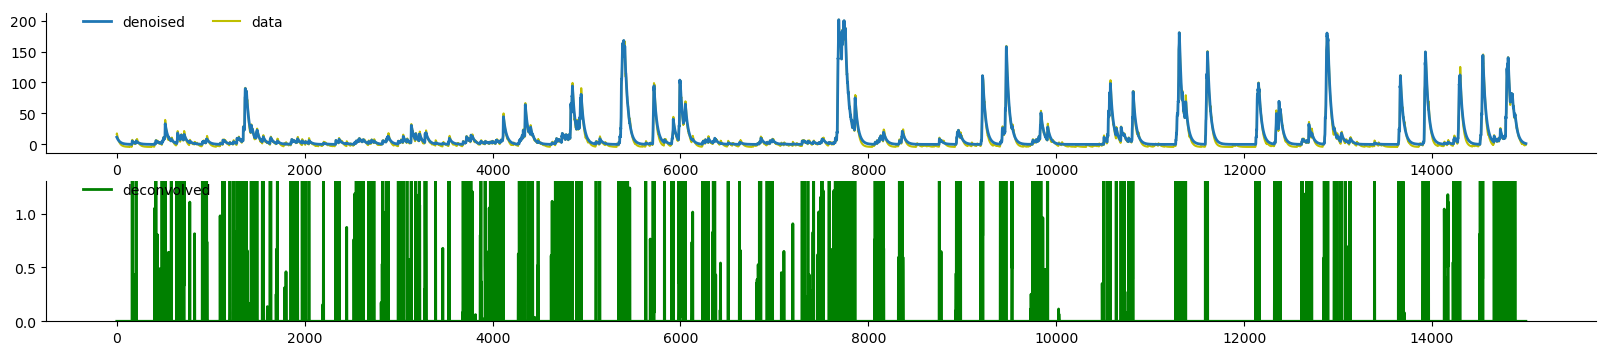

In [29]:
plot_trace(calcio1, c ,b,s )

### With $\ell_0$ penalty the problem is non-convex, however, we obtain a good local minimum

CPU times: total: 469 ms
Wall time: 141 ms


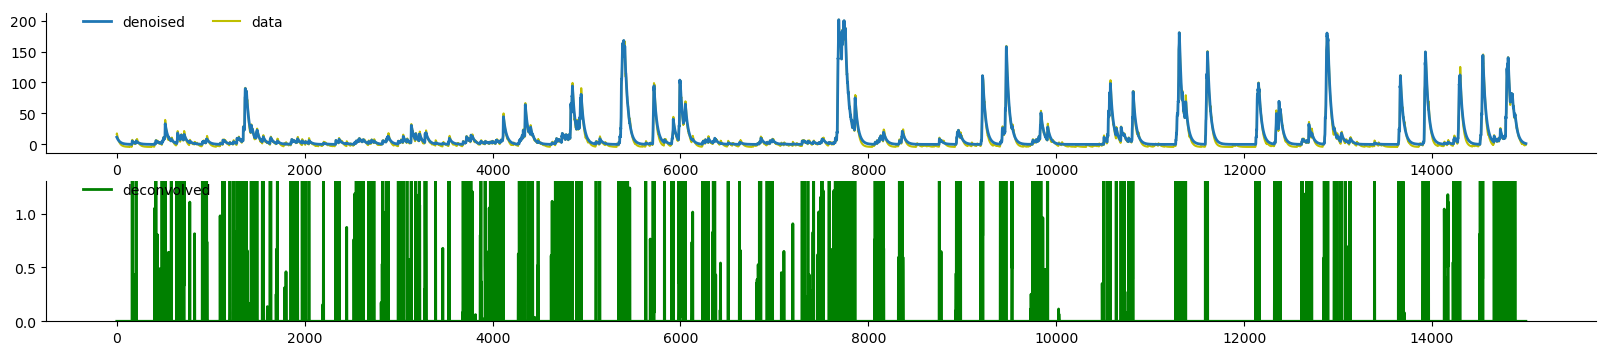

In [30]:
%time c, s, b, g, lam = deconvolve(calcio1, penalty=0)
plot_trace(calcio1, c ,b,s )

### If we have a good idea about the fluorescence baseline, its time constant and it size for 1AP, we can provide this information
$g$ is related to the decay time $\tau_d$ of the exponetial Ca response kernel $e^{-t/\tau_d}$ as $g=e^{-\frac{1}{\tau_d r}}$ with decay time $\tau_d$ in seconds and imaging rate r in Hz.

CPU times: total: 0 ns
Wall time: 4.24 ms


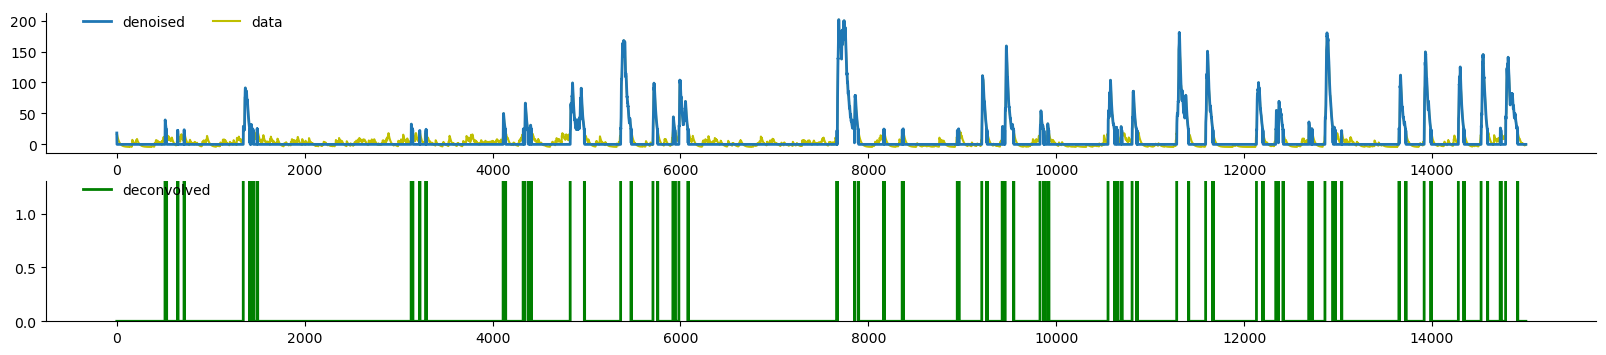

In [56]:
# Here we provide the ground truth values for b and g. 
# The Ca response kernel to 1 AP has maximal amplitude 1 and we pick s_min slightly larger than 1/2.
%time c, s = oasisAR1(calcio1, g=0.1, s_min=20)
plot_trace(calcio1, c ,b,s )

### If $g$ is not provided, it is estimated from the autocorrelation. We can improve upon it, in particularly if the spiking signal has some significant autocorrelation.
In function deconvolve, we already multiply the autocorrelation estimate by some fudge_factor that is close to but smaller than 1, which increases robustness

In [43]:
estimate_parameters(calcio1, 1)[0]

array([0.98896657])

CPU times: total: 422 ms
Wall time: 131 ms


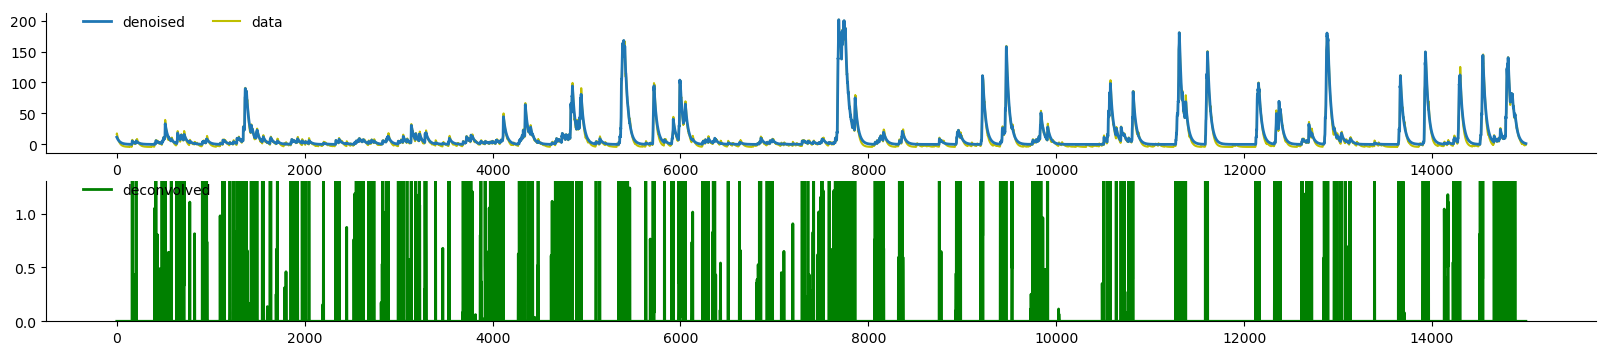

In [57]:
# no optimization of g
#y, true_c, true_s = map(np.squeeze, gen_sinusoidal_data(N=1, b=true_b, seed=0))
%time c, s, b, g, lam = deconvolve(calcio1, penalty=0)
# the line below uses the direct autocorrelation estimate without fudge_factor, yielding worse results
# %time c, s, b, g, lam = deconvolve(y, g=estimate_parameters(y, 1)[0], penalty=0) 
plot_trace(calcio1, c ,b,s )

CPU times: total: 859 ms
Wall time: 306 ms


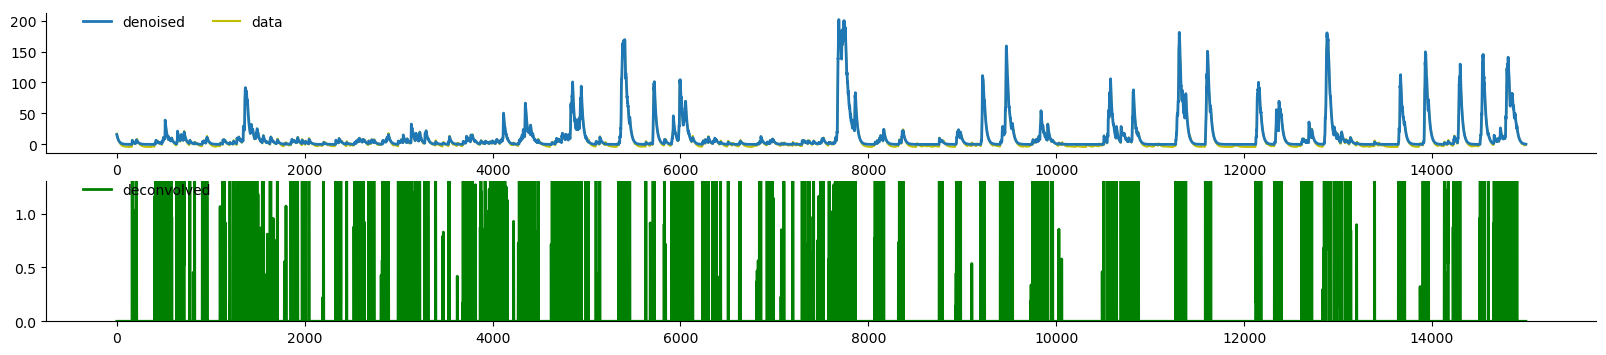

In [ ]:
# optimization of g. optimize_g=5 uses 5 large isolated calcium events to update g.
%time c, s, b, g, lam = deconvolve(calcio1, penalty=0, optimize_g=200) #no effect
plot_trace(calcio1, c ,b,s )

# Load some other raw fluorescence data 
This data happend to have a slow rise time and we model it with an AR(2) process

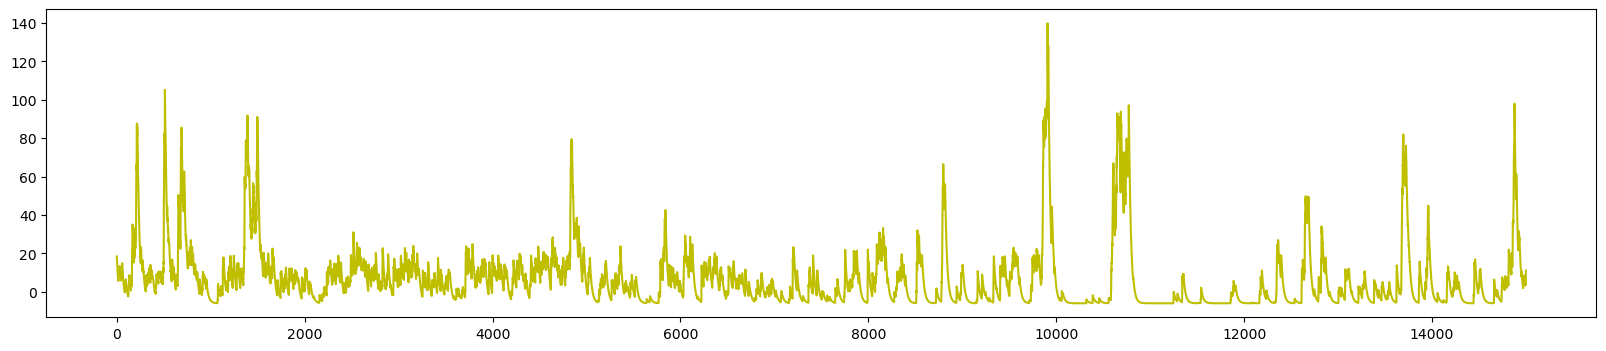

In [64]:
# here we generate some simulated fluorescence data and plot it
calcio2 = np.array(a['neural'][1])
plt.figure(figsize=(20,4))
plt.plot(calcio2, c='y')
plt.show()

# Deconvolve 

### With $\ell_1$ penalty we obtain the global minimum of the convex problem 
If we only have the trace and no further info, simply calling deconvolve tries to estimate it from the data 

CPU times: total: 703 ms
Wall time: 213 ms


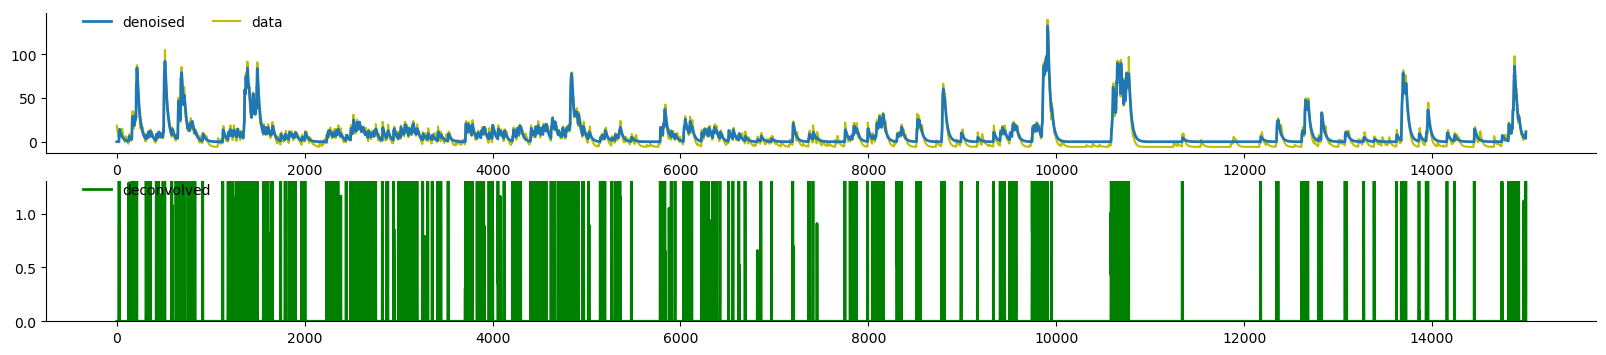

In [66]:
# g=(None,None) because we want to use an AR(2) model, but don't know the parameters
%time c, s, b, g, lam = deconvolve(calcio2, g=(None,None), penalty=1) 
plot_trace(calcio2, c ,b,s )

### With $\ell_0$ penalty the problem is non-convex, however, we obtain a good local minimum

CPU times: total: 1.17 s
Wall time: 398 ms


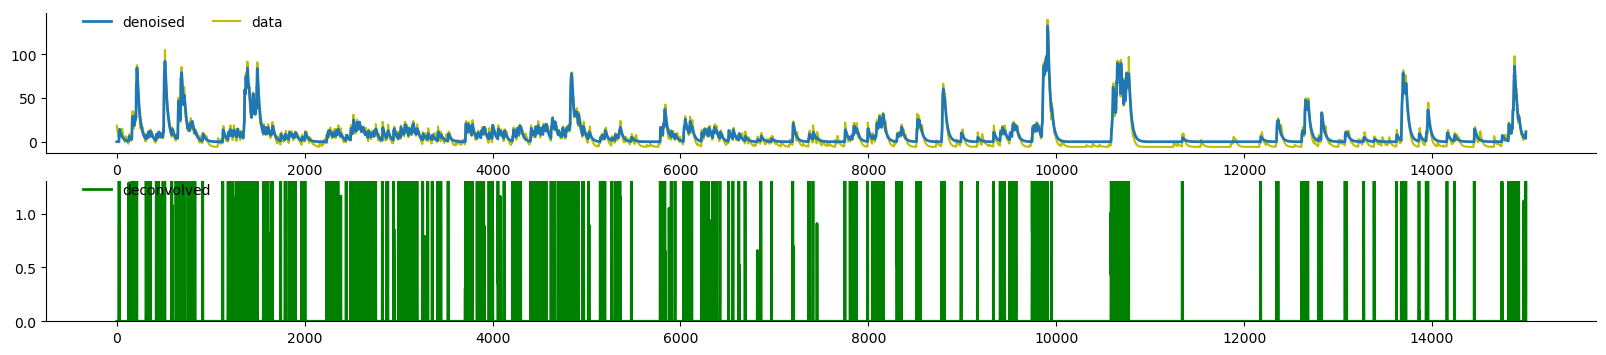

In [67]:
%time c, s, b, g, lam = deconvolve(calcio2, g=(None,None), penalty=0)
plot_trace(calcio2, c ,b,s )

### We might further improve upon the initial estimate of $g$

CPU times: total: 41.1 s
Wall time: 10.1 s


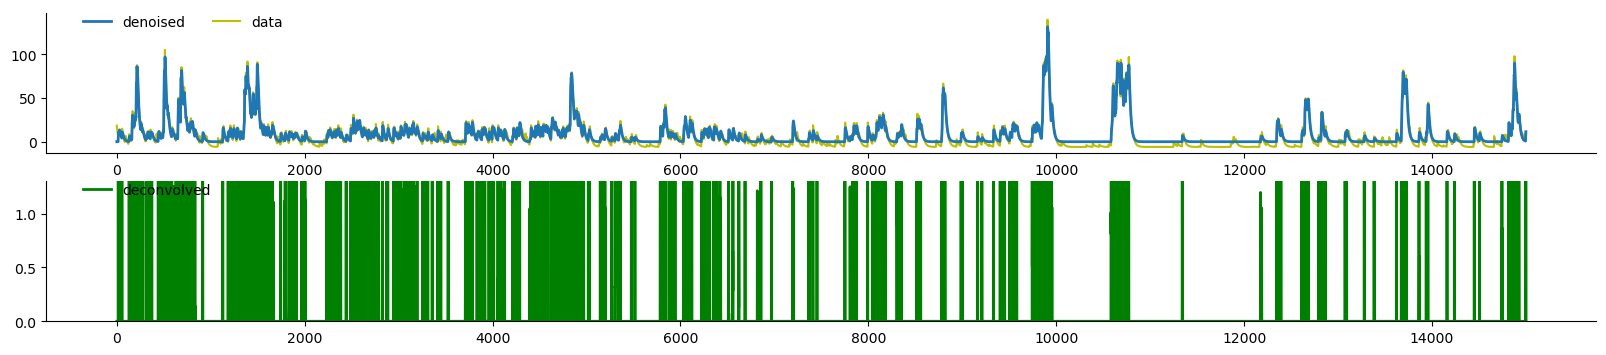

(1.6514151447077774, -0.667767416308867)

In [155]:
# this is currently slow, we hope to still improve speed as well as robustness
%time c, s, b, g, lam = deconvolve(calcio2, g=(None,None), penalty=0, optimize_g=1, max_iter=5) 
plot_trace(calcio2, c ,b,s )
g

### If we have a good idea about the fluorescence baseline, and its time constants we can provide this information
$g=(g_1,g_2)$ is related to the decay time $\tau_d$ and rise time $\tau_r$ (in seconds) of the Ca response kernel $e^{-t/\tau_d}-e^{-t/\tau_r}$ as <br>
$g_1=e^{-\frac{1}{\tau_d r}}+e^{-\frac{1}{\tau_r r}}$ and <br>
$g_2=-e^{-\frac{1}{\tau_d r}}\cdot e^{-\frac{1}{\tau_r r}}$ with imaging rate r in Hz.

c:\Users\54115\anaconda3\envs\oasis\Lib\site-packages\oasis\functions.py:432: RuntimeWarning: overflow encountered in exp
  h = (np.exp(log(d) * np.arange(1, w + 1)) -


CPU times: total: 141 ms
Wall time: 53.1 ms


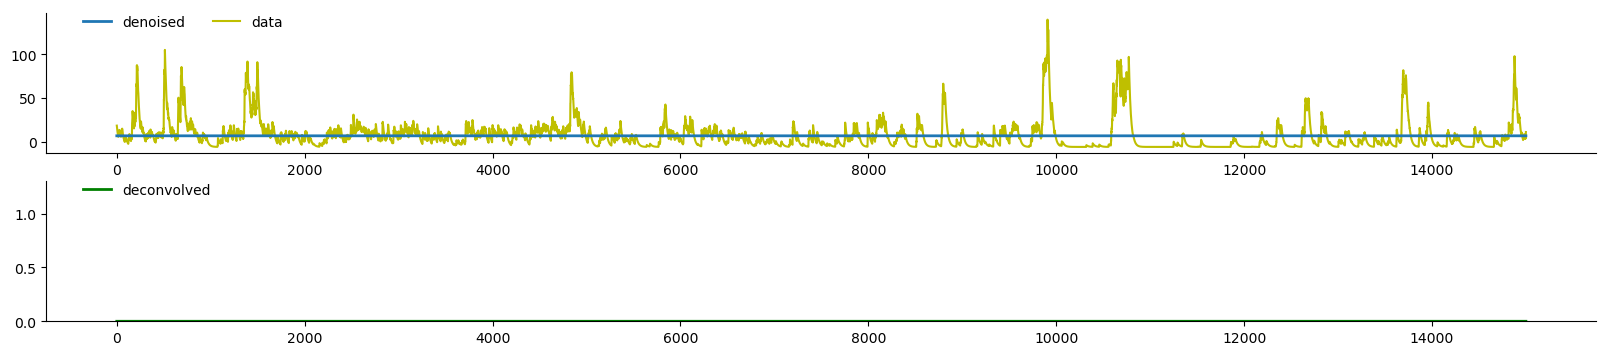

(90, -0.1)

In [80]:
# Here we provide the ground truth values for g. 
%time c, s, b, g, lam = deconvolve(calcio2, (90,-.1))
plot_trace(calcio2, c ,b,s )
g

#### We can also opt for a quick but less accurate greedy method 

CPU times: total: 15.6 ms
Wall time: 65.2 ms


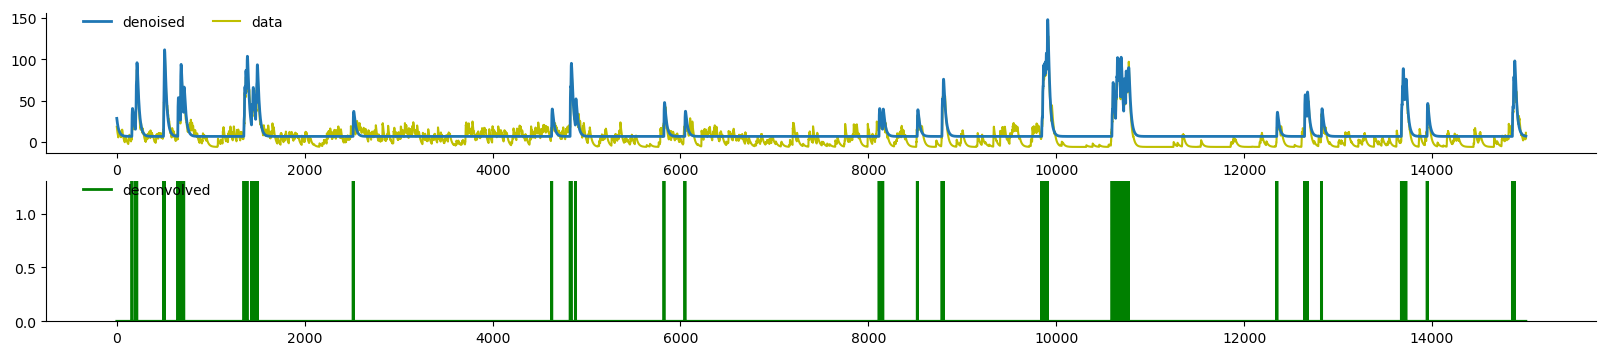

In [129]:
# Here we provide the ground truth values for b and g and we pick s_min slightly larger than 1/2.
%time c, s = oasisAR2(calcio2, 1.7,-.712, s_min=8)
plot_trace(calcio2, c ,b,s )


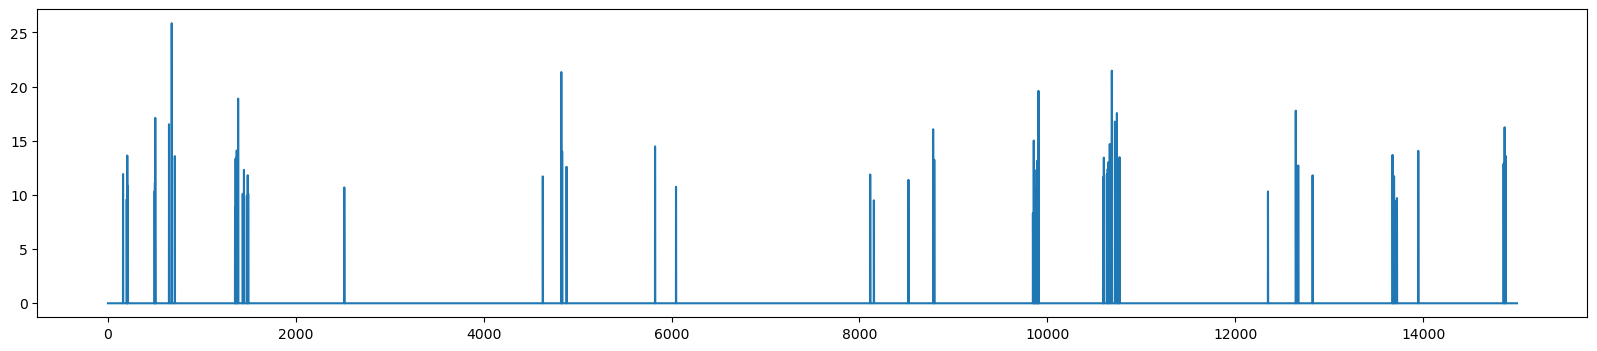

In [130]:
plt.figure(figsize=(20,4))
plt.plot(s)
plt.show()

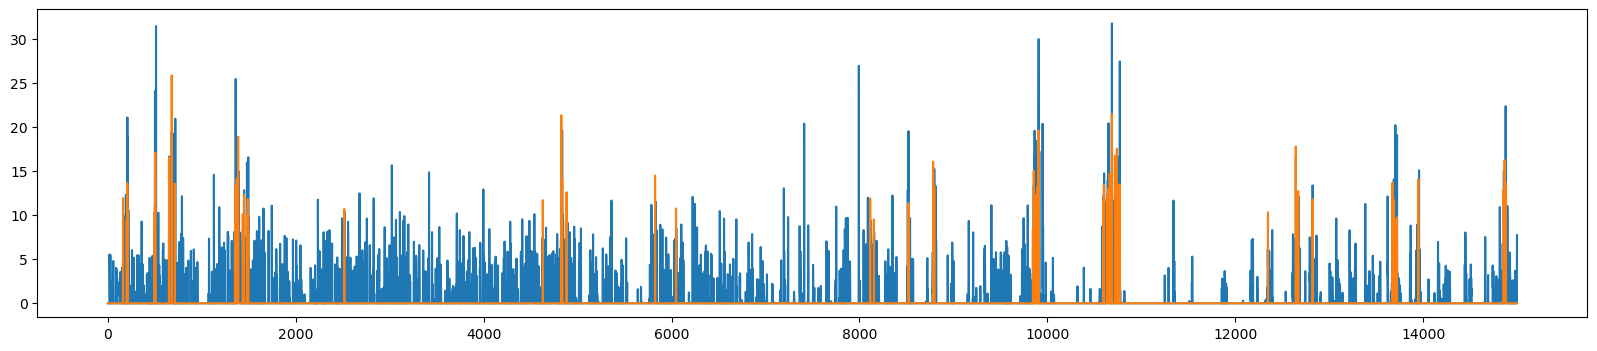

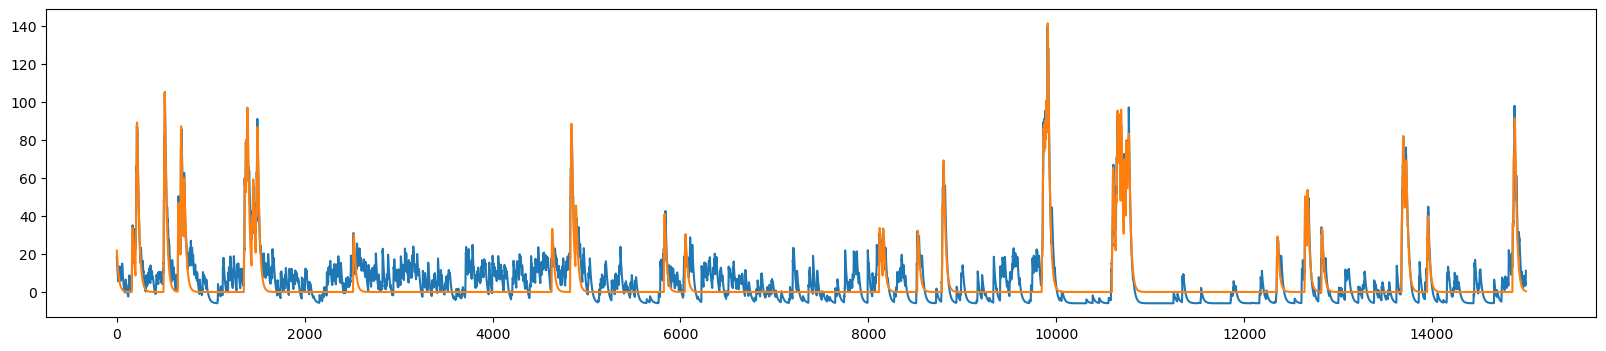

In [131]:
#check results
import pandas as pd
p1 = r'c:\Users\54115\Desktop\Doctorado\ARCHIVOS\Simon - Tesis\Dia 0\simon_objJUNTAS_sesion1_S_sampleo12000_obj0.csv'
dfS = pd.read_csv(p1)
p2 = r'c:\Users\54115\Desktop\Doctorado\ARCHIVOS\Simon - Tesis\Dia 0\simon_objJUNTAS_sesion1_C_sampleo12000_obj0.csv'
dfC = pd.read_csv(p2)

plt.figure(figsize=(20,4))
plt.plot(list(dfS['Neuron1'])) 
plt.plot(s)
plt.show()

plt.figure(figsize=(20,4))
plt.plot(list(dfC['Neuron1']))
plt.plot(c)
plt.show()

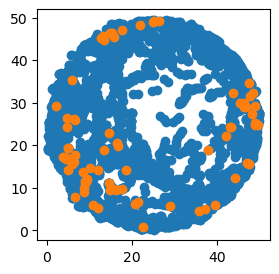

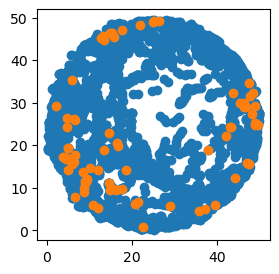

In [134]:
def mapa_bin(spikes,x,y,thr = 0):
    spikes_bin = [1 if x > thr else 0 for x in spikes]

    # Filtrar posiciones donde spikes_bin = 1
    x_red = [x[i] for i in range(len(spikes_bin)) if spikes_bin[i] == 1]
    y_red = [y[i] for i in range(len(spikes_bin)) if spikes_bin[i] == 1]
    return x_red, y_red

x = list(dfS['x'])
y = list(dfS['y'])
x_red, y_red = mapa_bin(list(dfS['Neuron1']),x,y)
x_red1, y_red1 = mapa_bin(s,x,y)
plt.figure(figsize=(3,3))
plt.scatter(x_red,y_red)
plt.scatter(x_red1,y_red1)
plt.show()

simon_objJUNTAS_sesion1_C_sampleo12000_obj0.csv
Rango Intercuartílico (IQR): 10.779842855455398
Desviación Mediana Absoluta (MAD): 4.537127700206534


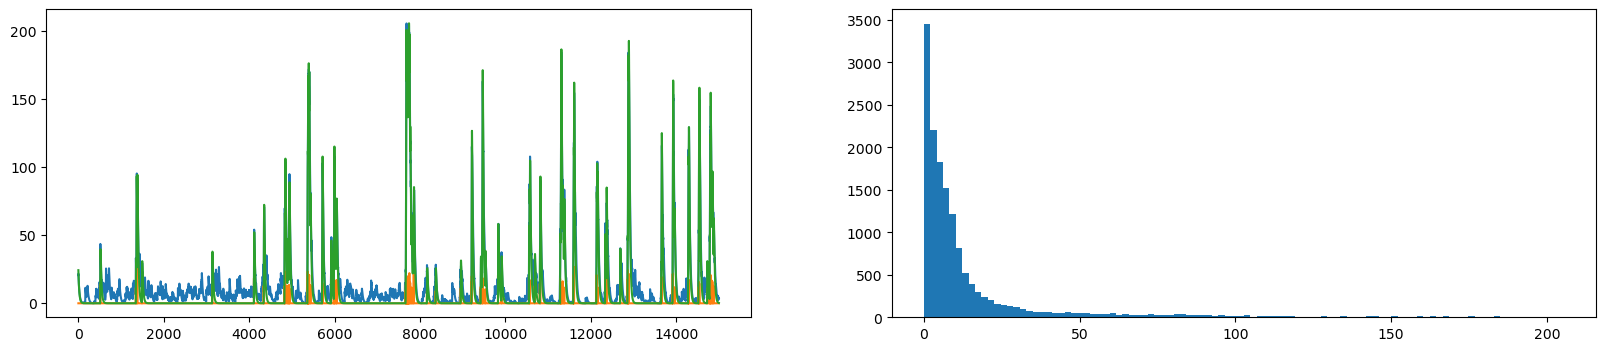

Rango Intercuartílico (IQR): 14.477251298818516
Desviación Mediana Absoluta (MAD): 7.065657180757647


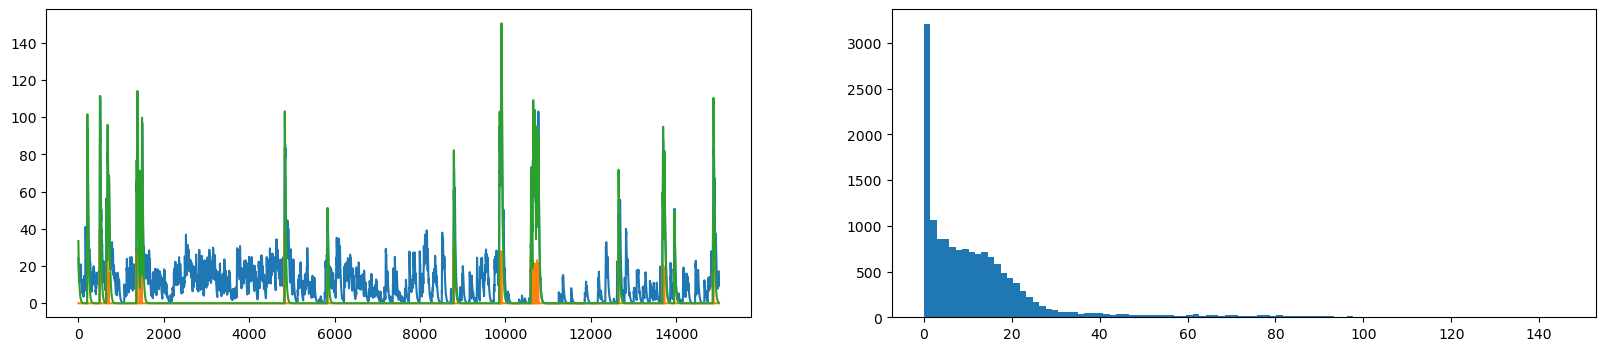

Rango Intercuartílico (IQR): 3.8230381804907925
Desviación Mediana Absoluta (MAD): 1.4887014487419175


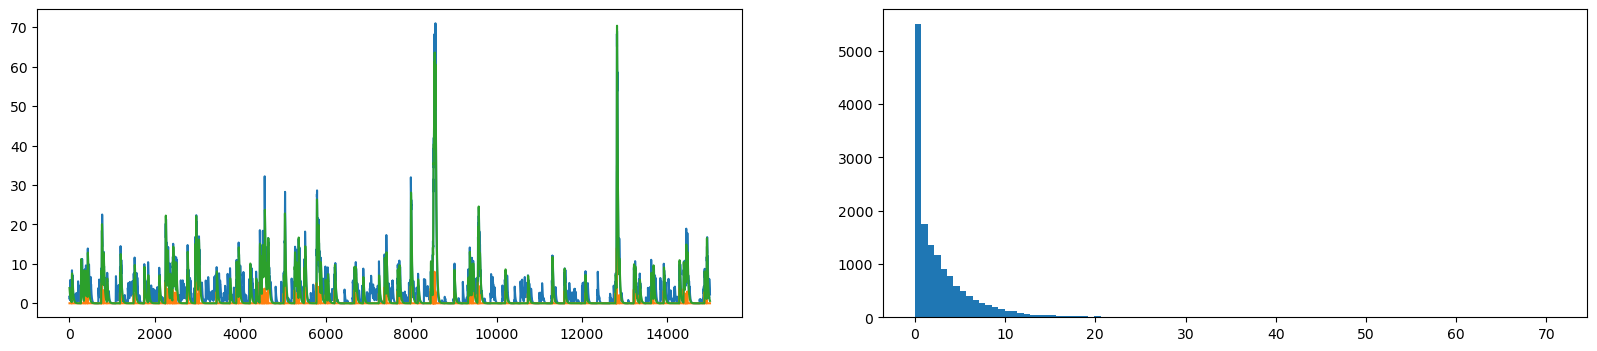

Rango Intercuartílico (IQR): 5.254704981908478
Desviación Mediana Absoluta (MAD): 2.490484500269931


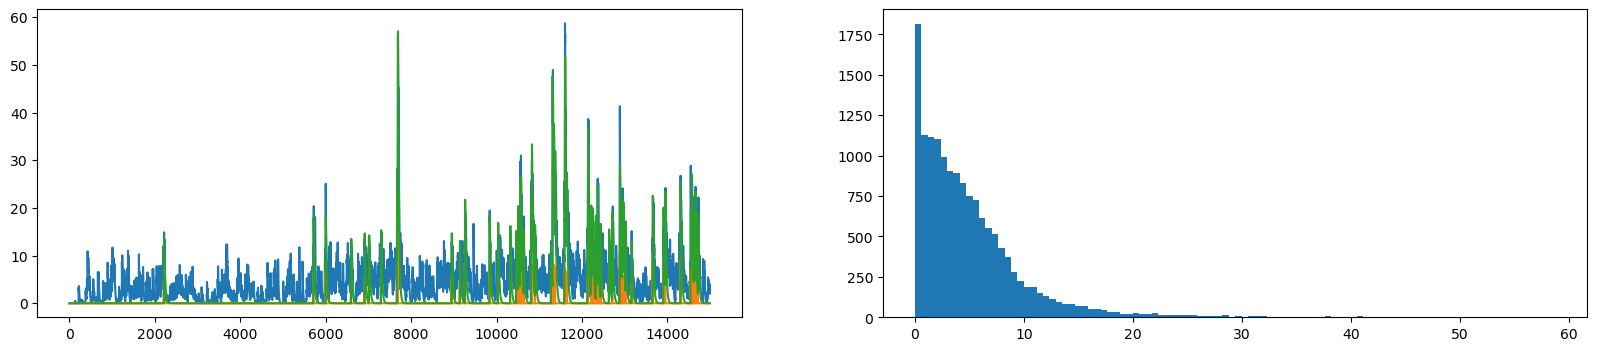

simon_objJUNTAS_sesion2_C_sampleo12000_obj0.csv
Rango Intercuartílico (IQR): 16.559771363833207
Desviación Mediana Absoluta (MAD): 4.988660042681794


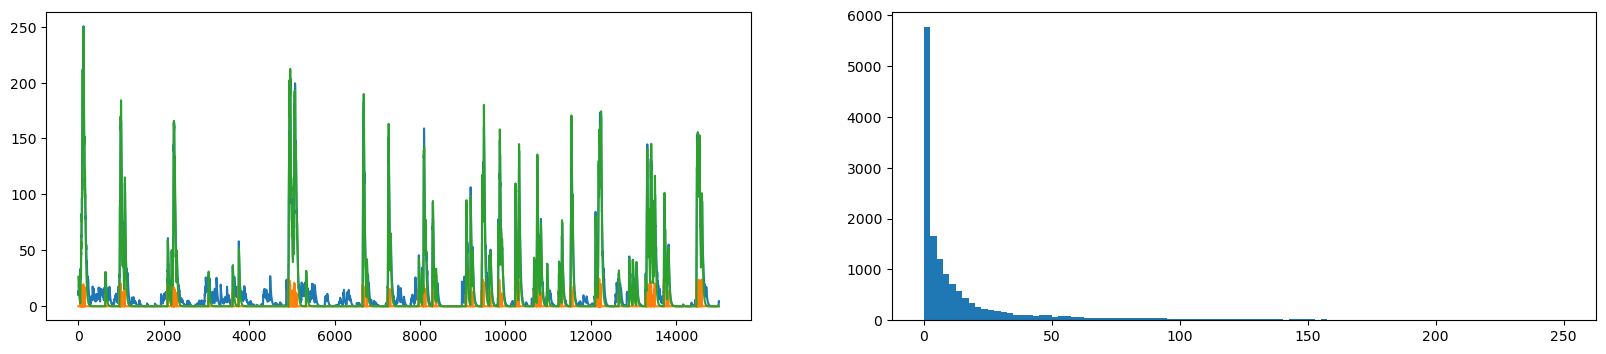

Rango Intercuartílico (IQR): 14.278748647228454
Desviación Mediana Absoluta (MAD): 5.2615272822235575


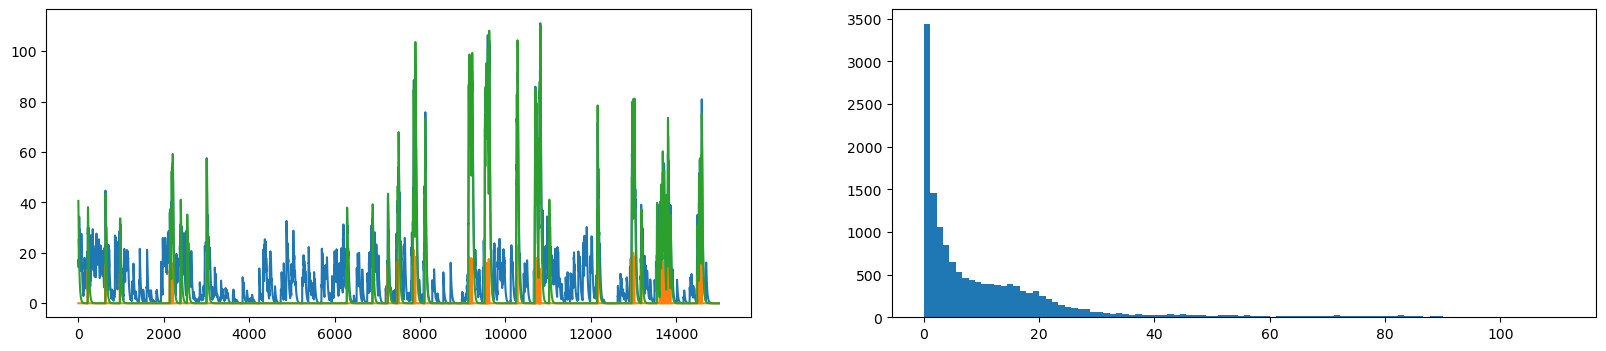

Rango Intercuartílico (IQR): 3.586006252556399
Desviación Mediana Absoluta (MAD): 1.3089958413458853


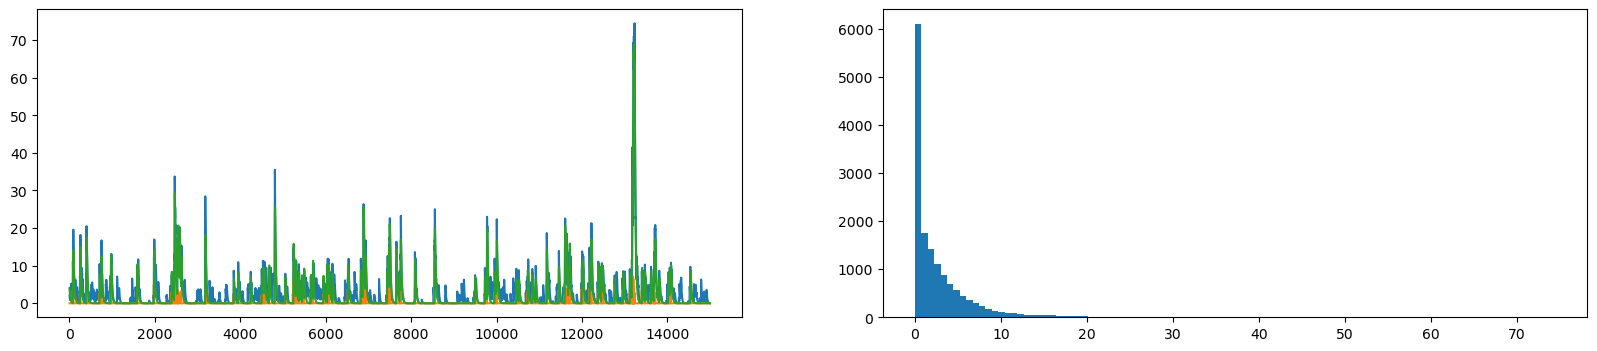

Rango Intercuartílico (IQR): 6.508617311623883
Desviación Mediana Absoluta (MAD): 3.050503866734443


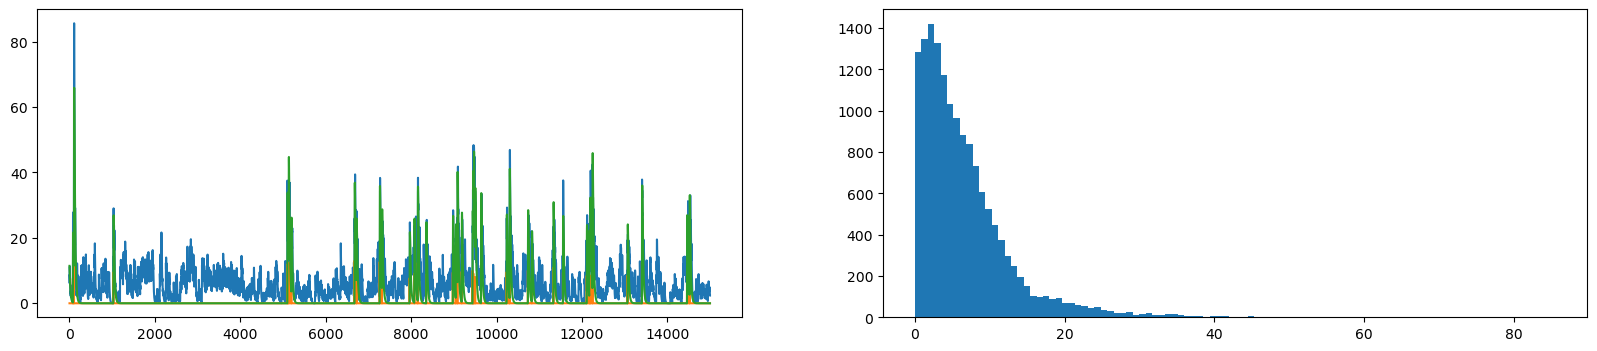

simon_objJUNTAS_sesion3_C_sampleo12000_obj0.csv
Rango Intercuartílico (IQR): 13.625871906711524
Desviación Mediana Absoluta (MAD): 4.438500810134392


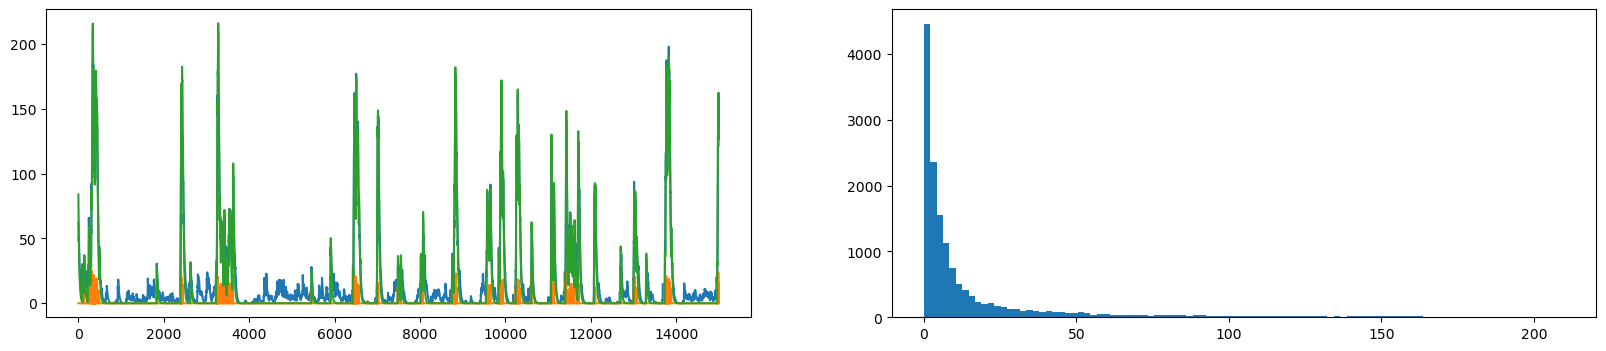

Rango Intercuartílico (IQR): 11.9025634554729
Desviación Mediana Absoluta (MAD): 5.233546866742574


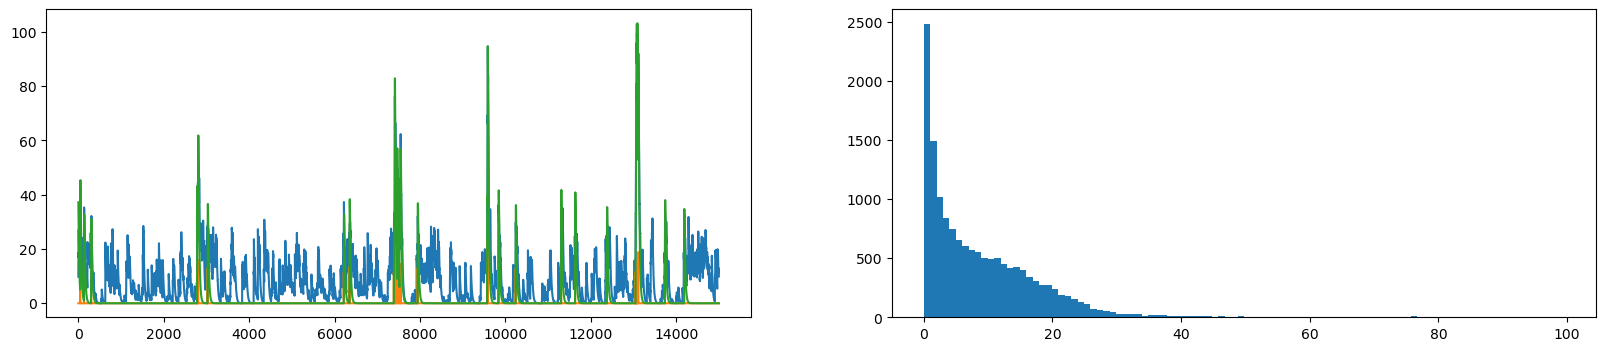

Rango Intercuartílico (IQR): 3.482649896369977
Desviación Mediana Absoluta (MAD): 1.3016163251706379


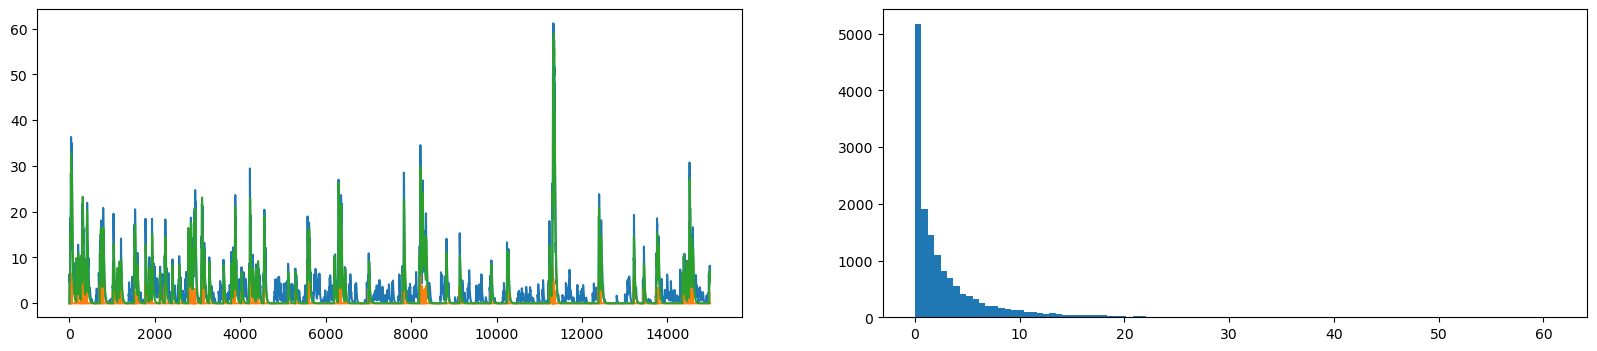

Rango Intercuartílico (IQR): 4.971889515760207
Desviación Mediana Absoluta (MAD): 2.395842713179143


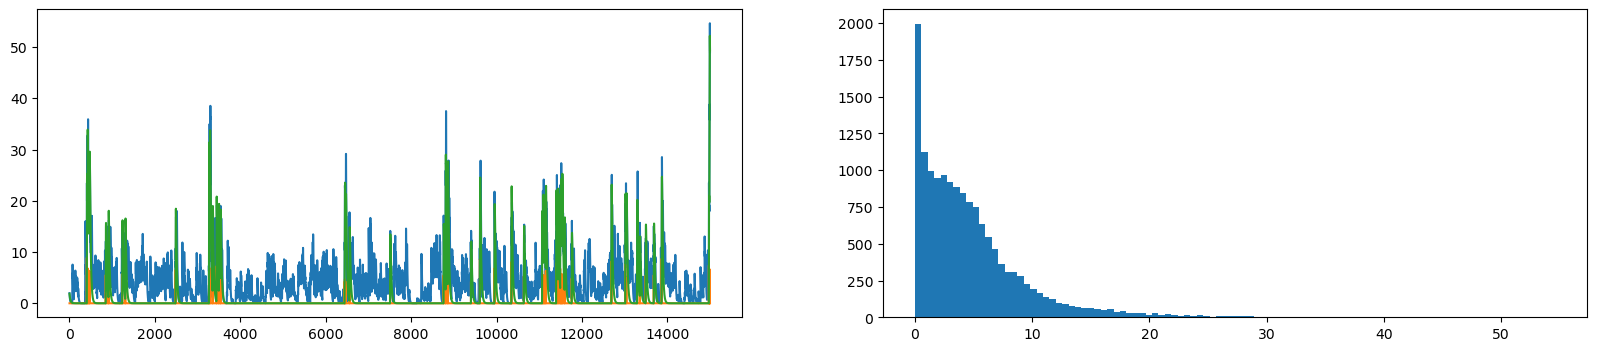

In [176]:
p2 = 'c:/Users/54115/Desktop/Doctorado/ARCHIVOS/Simon - Tesis/Dia 0/'
arch = ['simon_objJUNTAS_sesion1_C_sampleo12000_obj0.csv', 'simon_objJUNTAS_sesion2_C_sampleo12000_obj0.csv',
         'simon_objJUNTAS_sesion3_C_sampleo12000_obj0.csv']
from scipy.stats import entropy
plot = True
for j in range(len(arch)):
    print(arch[j])
    dfC = pd.read_csv(p2 + arch[j])
    df_deconv = pd.DataFrame()
    df_denoise = pd.DataFrame()
    for i in dfC.columns[1:-3][:4]:
        #print(i)
        calcio = np.array(dfC[i]) + abs(np.min(np.array(dfC[i])) )
        q1 = np.percentile(calcio, 25)
        q3 = np.percentile(calcio, 75)
        iqr = q3 - q1
        print(f"Rango Intercuartílico (IQR): {iqr}")

        # 4. Coeficiente de variación (CV)
        media = np.mean(calcio)
        desviacion_estandar = np.std(calcio, ddof=1)
        cv = desviacion_estandar / media
        #print(f"Coeficiente de Variación (CV): {cv}")

        percentiles = np.percentile(calcio, [10, 25, 50, 75, 90])
        #print(f"Percentiles (10, 25, 50, 75, 90): {percentiles}")

        # 6. Desviación mediana absoluta (MAD)
        mediana = np.median(calcio)
        mad = np.median(np.abs(calcio - mediana))
        print(f"Desviación Mediana Absoluta (MAD): {mad}")
        c, s = oasisAR2(calcio, 1.7,-.712, s_min=int(mad*2))
        df_deconv[i] = s
        df_denoise[i] = c
        if plot:
            fi, ax = plt.subplots(1,2,figsize=(20,4)) 
            ax[0].plot(calcio)
            ax[0].plot(s)
            ax[0].plot(c)
            ax[1].hist(calcio, bins=100)
            plt.show()

    #df_deconv.to_csv('OASIS_simon_objJUNTAS_sesion' +str(j+1) +'_S_sampleo12000_obj0_deconv.csv')#, index=False)
    #df_denoise.to_csv('OASIS_simon_objJUNTAS_sesion' +str(j+1) +'_C_sampleo12000_obj0_denoise.csv')#, index=False)